In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from sklearn.metrics import accuracy_score
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import os

plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels1, 19)

2022-12-16 15:32:22.648757: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import pandas as pd
data = pd.read_csv('../data/FER.csv')
df = pd.DataFrame(data)

In [81]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [91]:
df.pixels[0]
len(np.array(f['pixels'].split()))

2304

In [4]:
df.Usage.value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [5]:
df.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [79]:
#check target labels
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Fear,5121
2,Sad,6077
3,Neutral,6198
4,Happy,8989
5,Surprise,4002
6,Digust,547


In [25]:
emotion_map

{0: 'Angry',
 1: 'Digust',
 2: 'Fear',
 3: 'Happy',
 4: 'Sad',
 5: 'Surprise',
 6: 'Neutral'}

In [46]:
48*48

2304

In [49]:
f=df[df['emotion'] == 0].iloc[0]



len(np.array(f['pixels'].split()))
img = np.array(f['pixels'].split()).reshape(48,48)
img

array([['70', '80', '82', ..., '52', '43', '41'],
       ['65', '61', '58', ..., '56', '52', '44'],
       ['50', '43', '54', ..., '49', '56', '47'],
       ...,
       ['91', '65', '42', ..., '72', '56', '43'],
       ['77', '82', '79', ..., '105', '70', '46'],
       ['77', '72', '84', ..., '106', '109', '82']], dtype='<U3')

/var/folders/gq/3rtsgkd97h7djl6gyntg3f3r0000gn/T/ipykernel_14540/3310895179.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([image.astype(np.uint8), emotion])


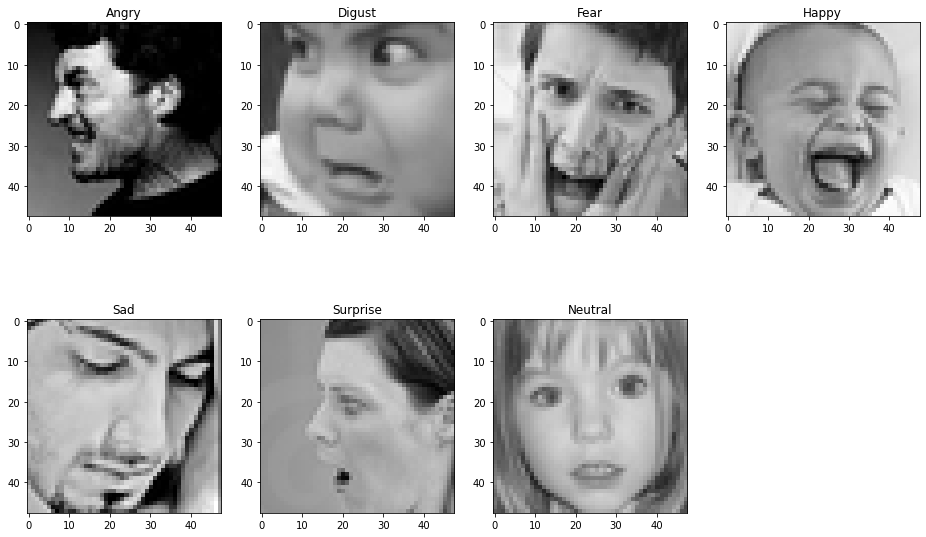

In [90]:
def row2image(row):
    pixels, emotion = row['pixels'], emotion_map[row['emotion']]
    img = np.array(pixels.split())
    img = img.reshape(48,48)
    image = np.zeros((48,48,3))
    image[:,:,0] = img
    image[:,:,1] = img
    image[:,:,2] = img
    return np.array([image.astype(np.uint8), emotion])

plt.figure(0, figsize=(16,10))
for i in range(1,8):
    face = data[data['emotion'] == i-1].iloc[12]
    img = row2image(face)
    plt.subplot(2,4,i)
    plt.imshow(img[0])
    plt.title(img[1])

In [19]:
img[0].shape

(48, 48, 3)

In [20]:
data

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


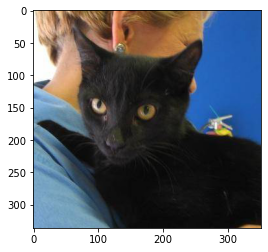

In [59]:
#Unzip files to folder
base_dir = '../dogs-vs-cats'
train_dir = '../data/train'
test_dir = '../data/test'

# Create train and test list
import glob
train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))

# Splitting
from sklearn.model_selection import train_test_split
train_list, val_list = train_test_split(train_list, test_size=0.2)

from PIL import Image

img = Image.open(train_list[14])
#label = train_list[12][1]
plt.imshow(img)
#plt.title('Image with label %d' % (label))
plt.show()

In [71]:
import torch
import torchvision
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

path = '../data/Img_Y.JPG'
Image.open('../data/Img_Y.JPG')

train = torch.utils.data.Dataset(path, transform=transform)

train_loader = torch.utils.data.DataLoader(train, batch_size=1, shuffle=False, num_workers=1)

for (inputs, targets) in enumerate(train_loader):
    print(inputs,targets)

TypeError: Dataset() takes no arguments

In [3]:
data = pd.read_csv('../data/Fraud/fraudTrain.csv')
df = pd.DataFrame(data)
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [4]:
df.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

In [92]:
import numpy as np

x = np.arange(1,10,1)

In [93]:
x

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [94]:
np.random.randint(0, 2, size=(1, 2, 3))

array([[[0, 1, 0],
        [1, 0, 0]]])

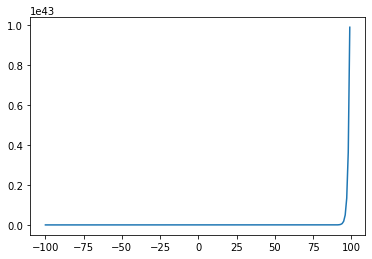

In [108]:
x = np.arange(-100,100)
y1 = 1/(1+np.exp(-x))
y2 = np.exp(x)

import matplotlib.pyplot as plt
#plt.plot(x,y1)
plt.plot(x,y2)

In [115]:
np.exp(100)

2.6881171418161356e+43

In [116]:
w = np.array([[2],[1]])
w

array([[2],
       [1]])

In [ ]:
W[0] * x + w[1] * y + c = 0

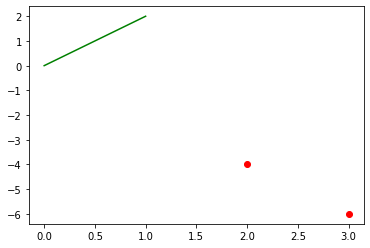

In [141]:
x1 = 2
x2 = 3

c = 0
y1 = -c/w[1] -w[0]/w[1] * x1
y2 = -c/w[1] -w[0]/w[1] * x2


plt.plot((x1,x2),(y1,y2),'ro')



plt.plot((0,w[1]),(0,w[0]),'g')

In [142]:
print(y1,y2)

[-4.] [-6.]


In [143]:
(y2-y1)/(x2-x1)

array([-2.])

In [145]:
w

array([[2],
       [1]])

In [5]:
import pandas as pd

data = pd.read_excel('../data/creditdata/Credit_informations.xlsx')
df = pd.DataFrame(data)

In [147]:
df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,home_ownership,annual_inc,verification_status,...,last_pymnt_amnt,last_credit_pull_d,policy_code,application_type,acc_now_delinq,total_rev_hi_lim,emp_length_int,mths_since_earliest_cr_line,mths_since_issue_d,good_bad
0,5000,5000,4975.0,1,10.65,162.87,2.2,1,24000.0,1,...,1,1,1,1,0,5000,10,395,72,1
1,2500,2500,2500.0,2,15.27,59.83,3.6,1,30000.0,2,...,2,2,1,1,0,2500,0,224,72,0
2,2400,2400,2400.0,1,15.96,84.33,3.8,1,12252.0,3,...,3,1,1,1,0,2400,10,193,72,1
3,10000,10000,10000.0,1,13.49,339.31,3.0,1,49200.0,2,...,4,3,1,1,0,10000,10,262,72,1
4,3000,3000,3000.0,2,12.69,67.79,2.8,1,80000.0,2,...,5,1,1,1,0,3000,1,263,72,1


In [6]:
df.shape

(461097, 44)

In [7]:
df.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'pymnt_plan',
       'purpose', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'initial_list_status',
       'out_prncp', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d', 'policy_code',
       'application_type', 'acc_now_delinq', 'total_rev_hi_lim',
       'emp_length_int', 'mths_since_earliest_cr_line', 'mths_since_issue_d',
       'good_bad'],
      dtype='object')

In [15]:
df.initial_list_status.value_counts()

1    298316
2    162781
Name: initial_list_status, dtype: int64

In [12]:
df.earliest_cr_line.unique

<bound method Series.unique of 0           1
1           2
2           3
3           4
4           5
         ... 
461092     23
461093    217
461094     34
461095    226
461096    192
Name: earliest_cr_line, Length: 461097, dtype: int64>

$\mathbf{w}_{t+1}^T\mathbf{x}_i = (\mathbf{w}_{t} + y_i\mathbf{x}_i)^T\mathbf{x}_{i} \newline
= \mathbf{w}_{t}^T\mathbf{x}_i + y_i ||\mathbf{x}_i||_2^2$

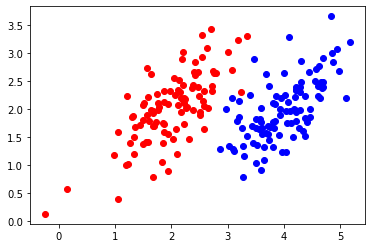

In [61]:
# generate data
# list of points 
import numpy as np 
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
np.random.seed(2)

means = [[2, 2], [4, 2]]
cov = [[.3, .2], [.2, .3]]
N = 100
X0 = np.random.multivariate_normal(means[0], cov, N).T
X1 = np.random.multivariate_normal(means[1], cov, N).T

X = np.concatenate((X0, X1), axis = 1)
y = np.concatenate((np.ones((1, N)), -1*np.ones((1, N))), axis = 1)
# Xbar 
X = np.concatenate((np.ones((1, 2*N)), X), axis = 0)

plt.plot(X[1,:100],X[2,:100],'ro')
plt.plot(X[1,100:],X[2,100:],'bo')

In [62]:
def h(w, x):    
    return np.sign(np.dot(w.T, x))

def has_converged(X, y, w):    
    return np.array_equal(h(w, X), y) 

def perceptron(X, y, w_init):
    w = [w_init]
    N = X.shape[1]
    d = X.shape[0]
    mis_points = []
    while True:
        # mix data 
        mix_id = np.random.permutation(N)
        for i in range(N):
            xi = X[:, mix_id[i]].reshape(d, 1)
            yi = y[0, mix_id[i]]
            if h(w[-1], xi)[0] != yi: # misclassified point
                mis_points.append(mix_id[i])
                w_new = w[-1] + yi*xi 
                w.append(w_new)
                
        if has_converged(X, y, w[-1]):
            break
    return (w, mis_points)

d = X.shape[0]
w_init = np.random.randn(d, 1)
(w, m) = perceptron(X, y, w_init)

KeyboardInterrupt: 

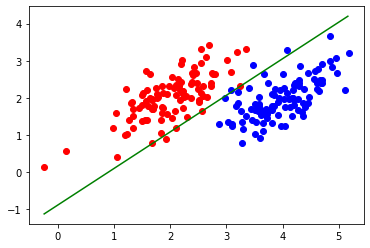

In [64]:
plt.plot(X[1,:100],X[2,:100],'ro')
plt.plot(X[1,100:],X[2,100:],'bo')
x1 = np.arange(X[1,:].min(),X[1,:].max(),0.1)
x2 = -(w[-1][0,0] + w[-1][1,0]*x1)/w[-1][2,0]
plt.plot(x1,x2,'g-')

In [45]:
w[-1]

array([[ 5.04082395],
       [-7.40039568],
       [ 7.81914367]])

In [48]:
w[-1][1,0]

-7.4003956808851745

In [58]:
X[1,:]

array([2.22096057, 2.70132234, 3.08493823, 2.02701417, 2.73223639,
       1.21171968, 2.22920603, 1.8637762 , 1.74682699, 2.37191737,
       4.47403369, 4.09281249, 4.22222334, 4.58438569, 4.74493118,
       3.6355797 , 5.19217738, 3.51075436, 3.93784332, 3.8787214 ])

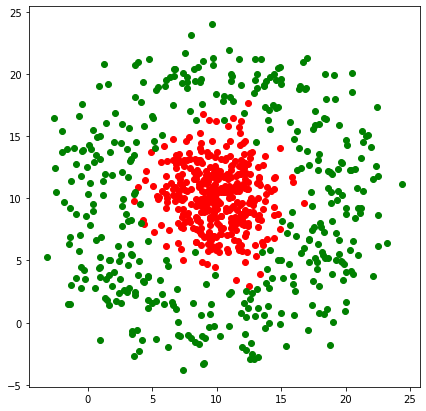

In [2]:
import numpy as np
import cvxopt
import matplotlib.pyplot as plt

# Gaussian center of the annulus

m_per_class = 400

mu = np.array([10, 10])
sigma = np.array([[6, 0], [0, 6]])
X1 = np.random.multivariate_normal(mu, sigma, m_per_class)

# Outer ring of annulus

r = 10
sigma = 2
theta = np.random.uniform(0, 2 * np.pi, m_per_class)
r = r + np.random.normal(0, sigma, m_per_class)
x, y = 10 + np.cos(theta) * r, 10 + np.sin(theta) * r
X2 = np.concatenate((x.reshape(-1, 1), y.reshape(-1, 1)), 1)
plt.figure(figsize = (7,7))
plt.plot(X1[:,0], X1[:,1], 'ro')
plt.plot(X2[:,0], X2[:,1], 'go')
plt.show()

In [3]:
# Combine the classes and set targets

X = np.concatenate((X1, X2), 0)
y = np.concatenate((-np.ones((m_per_class, 1)), np.ones((m_per_class, 1))), 0)
m = X.shape[0]
n = 2

def cvxopt_solve_qp(Q, c, A=None, b=None, E=None, d=None):
    Q = .5 * (Q + Q.T)  # make sure Q is symmetric
    args = [cvxopt.matrix(Q), cvxopt.matrix(c)]
    if A is not None:
        args.extend([cvxopt.matrix(A), cvxopt.matrix(b)])
        if E is not None:
            args.extend([cvxopt.matrix(E), cvxopt.matrix(d)])
    sol = cvxopt.solvers.qp(*args)
    if 'optimal' not in sol['status']:
        return None
    return np.array(sol['x']).reshape((Q.shape[1],))


# Kernels

def linear_kernel(X):
    return X @ X.T


def rbf_kernel(X, sigma):
    m = X.shape[0]
    K = np.zeros((m, m))
    for i in range(m):
        for j in range(m):
            K[i, j] = (X[i,:] - X[j,:]) @ (X[i,:] - X[j,:])
    K = np.exp(- K / 2 / sigma / sigma)
    return K
        
            
# QP problem: set Q, c, A, b

# Parameters are alpha's

# max_alpha [sum of alphas] - 1/2 sum_i,j alpha_i alpha_j y^i y^j <x^i,x^j>
# alpha_i >= 0
# sum alpha_i * y^i = 0

m = X.shape[0]
rbf_sigma = 2
c = - np.ones((m, 1))
# Q = (y @ y.T) * linear_kernel(X, rbf_sigma)
Q = (y @ y.T) * rbf_kernel(X, rbf_sigma)
A = - np.eye(m)
b = np.zeros((m, 1))
E = y.T
d = np.zeros((1, 1))

opt_params = cvxopt_solve_qp(Q, c, A, b, E, d)


     pcost       dcost       gap    pres   dres
 0: -6.7029e+01 -2.1588e+02  2e+03  3e+01  3e+00
 1: -1.7128e+02 -4.1377e+02  2e+03  2e+01  2e+00
 2: -4.3746e+02 -7.7771e+02  2e+03  2e+01  1e+00
 3: -9.7785e+02 -1.4242e+03  1e+03  1e+01  1e+00
 4: -2.3148e+03 -2.9284e+03  2e+03  1e+01  1e+00
 5: -3.9564e+03 -4.7569e+03  2e+03  1e+01  1e+00
 6: -8.1838e+03 -9.6301e+03  3e+03  1e+01  1e+00
 7: -1.5538e+04 -1.8694e+04  5e+03  1e+01  9e-01
 8: -2.5222e+04 -3.1030e+04  7e+03  7e+00  6e-01
 9: -2.9048e+04 -3.3089e+04  5e+03  3e+00  2e-01
10: -2.9001e+04 -3.3007e+04  5e+03  3e+00  2e-01
11: -2.8927e+04 -3.2869e+04  5e+03  3e+00  2e-01
12: -2.8872e+04 -3.1152e+04  3e+03  9e-01  8e-02
13: -2.9363e+04 -2.9622e+04  3e+02  5e-02  4e-03
14: -2.9475e+04 -2.9516e+04  4e+01  3e-04  3e-05
15: -2.9511e+04 -2.9513e+04  1e+00  4e-06  4e-07
16: -2.9513e+04 -2.9513e+04  2e-02  6e-08  5e-09
Optimal solution found.


In [70]:
X.shape, y.shape

((800, 2), (800, 1))

In [4]:
print('Alphas that are not zero:', opt_params[opt_params > 1e-5])
print('Corresponding labels:', y[opt_params > 1e-5])
print(opt_params[opt_params > 1e-5].shape, y[opt_params > 1e-5].shape)
opt_params[opt_params > 1e-5] @ y[opt_params > 1e-5]

Alphas that are not zero: [1.40874963e-05 6.09977890e+03 2.54685369e-05 1.46259271e+02
 1.42929976e+02 3.52831864e-05 5.49945137e+03 2.84081975e-04
 2.59552479e+03 8.92250110e+02 6.33242944e-05 1.60524706e+02
 4.55861782e-05 1.27325837e-05 1.21553871e-05 1.44166267e-05
 1.68392368e-05 1.03544848e-05 1.16495677e-05 6.49279795e+01
 1.82311257e+02 3.28991057e-05 8.51420902e+03 1.32004976e-05
 1.05424760e-05 1.17001086e+01 1.57428891e+00 1.80773837e-05
 1.19084307e-05 5.37830550e+02 2.21469791e+02 7.27022641e-05
 1.06549914e-05 1.30283172e-05 7.58215721e-05 5.00160124e+02
 3.66130382e-05 8.15654003e+02 8.90152488e+02 1.50895135e-05
 3.04470124e-05 3.43373417e+01 1.54363196e-05 1.24183146e-05
 1.76677504e-05 1.12242614e-05 1.07331982e-05 1.42195680e+03
 1.00575556e-05 2.34037393e+02 1.27449223e-05 1.65412560e+02
 4.51474377e-05 1.93633206e+02 1.86508981e+02 1.35949572e-05
 1.55813555e-05 2.44311269e-05 1.47103003e-05 5.30668135e+01
 4.61376603e+01 1.27147876e-05 7.02324928e+02 3.86495136e+0

array([0.00012014])

## SVD 

In [15]:
import numpy as np
from numpy.linalg import norm
from random import normalvariate
from math import sqrt
 
def random_unit_vector(size):
    unnormalized = [normalvariate(0, 1) for _ in range(size)]
    norm = sqrt(sum(v * v for v in unnormalized))
    return [v / norm for v in unnormalized]
 
def power_iterate(X, epsilon=1e-10):    
    """ Recursively compute X^T X dot v to compute weights vector/eignevector """
 
    n, m = X.shape
    start_v = random_unit_vector(m) # start of random surf
    prev_eigenvector = None
    curr_eigenvector = start_v
    covariance_matrix = np.dot(X.T, X)
 
    ## power iterationn until converges
    it = 0        
    while True:
        it += 1
        prev_eigenvector = curr_eigenvector
        curr_eigenvector = np.dot(covariance_matrix, prev_eigenvector)
        curr_eigenvector = curr_eigenvector / norm(curr_eigenvector)
 
        if abs(np.dot(curr_eigenvector, prev_eigenvector)) > 1 - epsilon:            
            return curr_eigenvector

def svd(X, epsilon=1e-10):
    """after computed change of basis matrix from power iteration, compute distance"""
    n, m = X.shape
    change_of_basis = []
 
    for i in range(m):
        data_matrix = X.copy()
 
        for sigma, u, v in change_of_basis[:i]:
            data_matrix -= sigma * np.outer(u, v) 
 
        v = power_iterate(data_matrix, epsilon=epsilon) ## eigenvector 
        u_sigma = np.dot(X, v) ## 2nd step: XV = U Sigma 
        sigma = norm(u_sigma)  
        u = u_sigma / sigma
 
        change_of_basis.append((sigma, u, v))
     
    sigmas, us, v_transposes = [np.array(x) for x in zip(*change_of_basis)]
 
    return sigmas, us.T, v_transposes            

if __name__ == "__main__":    
    dataset = np.random.random_sample((8, 3))
    results = svd(dataset)
    print("sigmas", results[0])
    print("u: data points in new coordinate system", results[1])
    print("v transpose: change of basis matrix", results[2]) 


sigmas [2.51659717 0.97051488 0.57769038]
u: data points in new coordinate system [[ 0.36855139 -0.07388287  0.60456633]
 [ 0.35239633  0.23596841  0.4956405 ]
 [ 0.36220494 -0.72649016 -0.08905773]
 [ 0.2295648   0.13486777 -0.38781721]
 [ 0.35594983 -0.3713044  -0.26500383]
 [ 0.4310871   0.1735486   0.0265164 ]
 [ 0.32499128  0.33358177 -0.31706192]
 [ 0.37140083  0.3370758  -0.24299831]]
v transpose: change of basis matrix [[ 0.4558225   0.42783626  0.78050111]
 [-0.76123617 -0.26702812  0.59094457]
 [-0.46124325  0.8635115  -0.20396701]]


In [18]:
dataset.shape,results[1].shape, results[0].shape, results[0].T.shape

((8, 3), (8, 3), (3,), (3,))

In [22]:
u = results[1]


1.0

## PCA

In [34]:
import numpy as np
 
def PCA(X , num_components):
     
    #Step-1
    X_meaned = X - np.mean(X , axis = 0)
     
    #Step-2
    cov_mat = np.cov(X_meaned , rowvar = False)
     
    #Step-3
    eigen_values , eigen_vectors = np.linalg.eigh(cov_mat)
     
    #Step-4
    sorted_index = np.argsort(eigen_values)[::-1]
    sorted_eigenvalue = eigen_values[sorted_index]
    sorted_eigenvectors = eigen_vectors[:,sorted_index]
     
    #Step-5
    eigenvector_subset = sorted_eigenvectors[:,0:num_components]
     
    #Step-6
    X_reduced = np.dot(eigenvector_subset.transpose() , X_meaned.transpose() ).transpose()
     
    return X_reduced

In [41]:
a = np.array([0.8]).reshape(1,1)
np.linalg.inv(a)

array([[1.25]])

In [42]:
a = np.arange(9).reshape(3,3)
a

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [7]:
import numpy as np
a = np.array([4,2,7,5])
b = np.array([(7,1),(2,5),(9,1),(4,3)])
i,j = b[np.argmax(a)]
i, j
np.max(a)

7

In [43]:
a.mean(axis=0)

array([3., 4., 5.])

In [52]:
((a[0,:]-a.mean(axis=0)).reshape(3,1)) @ ((a[0,:]-a.mean(axis=0)).reshape(1,3))

array([[9., 9., 9.],
       [9., 9., 9.],
       [9., 9., 9.]])

In [ ]:
## Implement PCA by Sklearn

from sklearn.decomposition import PCA
pca = PCA()
X_train = pca.fit_transform(X_train)
pca.explained_variance_ratio_
cumsum = np.cumsum(pca.explained_variance_ratio_)
dim = np.argmax(cumsum >= 0.90) + 1
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,33,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

In [ ]:
#Training process of Logistic Regression

K=len(np.unique(y_train))

theta = np.zeros((K, X_train.shape[1]))

def hypothesis(X, theta):
    K = theta.shape[0]
    m = X.shape[0]
    a = np.zeros((m, K))
    for k in range(K):
        a[:,k:k+1] = X @ theta[k:k+1,:].T
    e_a = np.exp(a)
    return e_a / e_a.sum(axis=1, keepdims=True)

def onehot(y, K):
    Y = np.zeros((y.shape[0], K))
    for k in range(K):
        Y[y.reshape(-1)==k,k] = 1
    return Y
    
def cost(X, y, theta):
    K = theta.shape[0]
    m = X.shape[0]
    yhat = hypothesis(X, theta)
    # Form the matrix delta(y=k)
    Y = onehot(y, K)
    J = 0
    for k in range(K):
        J = J - np.log(yhat[y.reshape(-1)==k,k]).sum()
    J = J / m
    # Get the gradient matrix for theta
    grad_J = (yhat - Y).T @ X
    return J, grad_J

alpha = 0.0001
for epoch in range(150000):
    J, grad_J = cost(X_train, y_train, theta)
    if epoch % 5000 == 0:
        print('Epoch %d: cost %f' % (epoch, J))
    theta = theta - alpha * grad_J